In [268]:
# !pip install pettingzoo

In [269]:
from pettingzoo.classic import connect_four_v3
import numpy as np
import matplotlib.pyplot as plt

import os
os.environ["SDL_VIDEODRIVER"] = "dummy"
from IPython.display import clear_output

# Using the PettingZoo environment

This notebook provides smalls chunks of code to get you started with the Connect4 project. You do not have to use this code in you final file, but you can if you wish to. 

In [270]:
env = connect_four_v3.env(render_mode="rgb_array")

env.reset()

# The main difference with the standard gym api is the way the environment is queried. The `step` method return `None`. 
# To get the data on the environment, use the `last` method
state, reward, terminated, truncated, info = env.last()

# state is a dictionary with two keys: observation and action_mask
print('shape observation\n', state["observation"].shape)  # Observation is a numpy array with three coordinates, indicating the positions of the pieces of player 0 and 1 on the the board
print('joueur 0\n', state["observation"][:, :, 0])  # Where the pieces of player 0 are
print('joueur 1\n', state["observation"][:, :, 1])  # Where the pieces of player 1 are

print('action mask\n', state["action_mask"])  # an array showing whether the actions are legal or nots


shape observation
 (6, 7, 2)
joueur 0
 [[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
joueur 1
 [[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
action mask
 [1 1 1 1 1 1 1]


In [271]:
env.reset()
env.step(0)

state, reward, terminated, truncated, info = env.last()

print('shape observation\n', state["observation"].shape) 
print('joueur 0\n', state["observation"][:, :, 0])  
print('joueur 1\n', state["observation"][:, :, 1])  

print('action mask\n', state["action_mask"])


shape observation
 (6, 7, 2)
joueur 0
 [[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
joueur 1
 [[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]]
action mask
 [1 1 1 1 1 1 1]


# Agents

Here are some implementations of trivial agents that you should be able to beat ultimately. 

In [272]:
class RandomPlayer:
    def __init__(self, rng=None):
        if rng is None:
            self.rng = np.random.default_rng()
        else:
            self.rng = rng

        self.name = "Random Player"

    def get_action(self, obs_mask, epsilon=None):
        return self.random_choice_with_mask(np.arange(7), obs_mask["action_mask"])

    def random_choice_with_mask(self, arr, mask):
        masked_arr = np.ma.masked_array(arr, mask=1 - mask)
        if masked_arr.count() == 0:
            return None
        return self.rng.choice(masked_arr.compressed())


In [273]:
class PlayLeftmostLegal:
    def __init__(self):
        self.name = "Left Player"

    def get_action(self, obs_mask, epsilon=None):
        for i, legal in enumerate(obs_mask["action_mask"]):
            if legal:
                return i
        return None


# Running a game


The following function runs a full game between the two agents. 

In [274]:
def play_game(env, agent0, agent1, display=False):
    done = False
    env.reset()
    obs, _, _, _, _ = env.last()
    while not done:
        for i, agent in enumerate([agent0, agent1]):
            action = agent.get_action(obs, epsilon=0)
            env.step(action)
            if display:
                clear_output(wait=True)
                plt.imshow(env.render())
                plt.show()
            obs, reward, terminated, _, _ = env.last()
            done = terminated
            if np.sum(obs["action_mask"]) == 0:
                if display: 
                    print('Draw')
                return 0.5
            if done:
                if display:
                    print(f"Player {i}: {agent.name} won")
                    print((obs['observation'][:, :, 0]- obs['observation'][:, :, 1]).shape)
                    print(obs['observation'][:, :, 0]- obs['observation'][:, :, 1])
                return i

In [316]:
def get_pts_up(board, l, c):
    if l <= 2:
        return 0
    lined_up = 1
    while board[l - lined_up, c ] == board[l, c]:
        lined_up += 1
        if lined_up == 4:
            break
    if lined_up >= 4:
        return 100
    if board[l - lined_up, c ] == 0:
        return lined_up
    return 0

def get_pts_right(board, l, c):
    if c >= 4:
        return 0
    right_possibility = 0
    left_possibility = 0
    lined_up = 1
    while board[l, c + lined_up] == board[l, c]:
        lined_up += 1
        if lined_up == 4:
            break
    if lined_up >= 4:
        return 100
    if board[l, c + lined_up] == 0:
        right_possibility = 1
    if c != 0 :
        if board[l, c - 1] == 0:
            left_possibility = 1
    return lined_up * (left_possibility + right_possibility)

def get_pts_right_down(board, l, c):
    if l >= 2 or c >= 3:
        return 0
    right_possibility = 0
    left_possibility = 0
    lined_up = 1
    while board[l + lined_up, c + lined_up] == board[l, c]:
        lined_up += 1
        if lined_up == 4:
            break
    if lined_up >= 4:
        return 100
    if board[l + lined_up, c + lined_up] == 0:
        right_possibility = 1
    if c != 0 and l != 0 :
        if board[l - 1, c - 1] == 0:
            left_possibility = 1
    return lined_up * (left_possibility + right_possibility)

def get_pts_right_up(board, l, c):
    if l <= 4 or c >= 4:
        return 0
    right_possibility = 0
    left_possibility = 0
    lined_up = 1
    try:
        while board[l - lined_up, c + lined_up] == board[l, c]:
            lined_up += 1
            if lined_up == 4:
                break
    except :
        print("Lined_up : ", lined_up)
        print("colonne qui bloque : ", c + lined_up)
        print("ligne qui bloque : ", l - lined_up)
        print('case de depart: ', l, c)
    if lined_up >= 4:
        return 100
    if board[l - lined_up, c + lined_up] == 0 :
        right_possibility = 1
    if c != 0 and l != 5 :
        if board[l + 1, c - 1] == 0:
            left_possibility = 1
    return lined_up * (left_possibility + right_possibility)

def evaluate_position(board):
    ''' Cette fonction  prend une grille de puissance 4 en entrée
    La fonction retourne un score
    Plus le score est élevé, plus le joueur 1 est en bonne position
    '''
    score_1 = 0
    score_2 = 0
    for l in range(6):
        for c in range(7):
            if board[l,c] == 1:
                score_1 = score_1 + get_pts_up(board, l, c) + get_pts_right(board, l, c) + get_pts_right_down(board, l, c) + get_pts_right_up(board, l, c)
            if board[l,c] == -1:
                score_2 = score_2 + get_pts_up(board, l, c) + get_pts_right(board, l, c) + get_pts_right_down(board, l, c) + get_pts_right_up(board, l, c)
    #print('Score de 1 :', score_1)
    #print('Score de 2 :', score_2)
    return score_1 - score_2


In [317]:
board = np.array([[0, 0, 0, 0, 0, 0, 0],
                  [0, 0, 0, 0, 0, 0, 0],
                  [0, 0, 0, 0, 0, 0, 0],
                  [0, 0, 0, 0, 0, 0, 0],
                  [0, 0, 0, 0, 0, 0, 0],
                  [0, 0, 0, 0, 0, 0, 0]])

#evaluate_position(board)
evaluate_best_choice(board)

3
4
4
4
1
1
1
max_score 4


3

In [318]:
def new_move(board, i):
    layer = 5
    bottom = board[layer,i]
    while bottom !=0 and layer>0 :
        #print(i,"on monte d'un cran")
        layer-=1
        bottom = board[layer,i]
    if layer == 0 and bottom !=0:
        print("on est tout en haut y a pas de place")
    else :
        new_board = board.copy()
        #print(i,"on va ajouter un pion ici")
        new_board[layer,i] = 1
    return new_board

def evaluate_best_choice(board):
    """ fonction qui return la liste des meilleurs coups à jouer """
    liste_future_score = []
    for i in range(7) :
        board_after_i = new_move(board, i)
        a = evaluate_position(board_after_i)
        print(a)
        liste_future_score.append(a)
    max_score = max(liste_future_score)
    print("max_score",max_score)
    indices = [i for i, score in enumerate(liste_future_score) if score == max_score]
    return np.random.choice(indices)

def get_move_score(board, i):
    board_after_i = new_move(board, i)
    a = evaluate_position(board_after_i)
    return a

In [319]:
evaluate_best_choice(board)

3
4
4
4
1
1
1
max_score 4


2

In [320]:
class Malynx:
    def __init__(self):
        self.name = "Malynx Player"

    def get_action(self, obs_mask, epsilon=None):
        board = obs_mask['observation'][:, :, 0]- obs_mask['observation'][:, :, 1]
        if np.sum(obs_mask['observation']) < 2 :
            return 3
        best_move_score = - 1000
        best_move = 10
        for i, legal in enumerate(obs_mask["action_mask"]):
            if legal:
                move_score = get_move_score(board, i)
                if move_score > best_move_score:
                    best_move_score = move_score
                    best_move = i
        return best_move

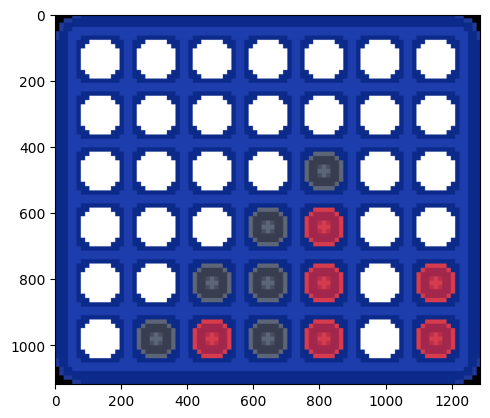

Player 1: Malynx Player won
(6, 7)
[[ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  0  1  0  0]
 [ 0  0  0  1 -1  0  0]
 [ 0  0  1  1 -1  0 -1]
 [ 0  1 -1  1 -1  0 -1]]


1

In [321]:
agent0 = RandomPlayer()
agent1 = Malynx()

play_game(env, agent0, agent1, display=True)

In [322]:
plt.hist([play_game(env, agent0, agent1, display=False) for _ in range(100)])
plt.show()

IndexError: index 7 is out of bounds for axis 1 with size 7

# Emulating a Gym environment

If we fix the opposite policy, the game from the point of view of the agent is equivalent to a Gym environment. The following class implements this simulation. Then any algorithm that would work in a gym environment with the same observations will work here. 

Note that we implemented the possibility to be the first or the second player. 

In [ ]:
class EnvAgainstPolicy: 
    def __init__(self, env, policy, first_player=True):
        self.policy = policy
        self.env = env
        self.first_player = first_player
        self.reset()

    def step(self, action):
        self.env.step(action)
        obs, reward, terminated, _, _ = self.env.last()
        if terminated: 
            self.last_step = obs, reward, True, False, {}
        else: 
            action = self.policy.get_action(obs)
            self.env.step(action)
            obs, reward, terminated, _, _ = self.env.last()
            self.last_step = obs, -reward, terminated, False, {}
        return self.last_step

    def reset(self):
        self.env.reset()
        if not(self.first_player): 
            obs, _, _, _, _ = self.env.last()
            action = self.policy.get_action(obs)
            self.env.step(action)

        self.last_step = self.env.last()
        return self.last_step

    def last(self):
        return self.last_step

# Evaluating an agent against a fixed policy: 

Using the environment above, we can evaluate the agent against this fixed policy. 

In [ ]:
def eval_against_policy(env, agent, policy, N_episodes=10, first_player=True):
    eval_env = EnvAgainstPolicy(env, policy, first_player=first_player)
    results = []
    for _ in range(N_episodes):
        done = False
        eval_env.reset()
        obs, _, _, _, _ = eval_env.last()
        while not done:
            action = agent.get_action(obs, epsilon=0)
            eval_env.step(action)
            obs, reward, done, _, _ = eval_env.last()
        results.append(reward)
    return results

We can see that if both players play randomly, there is a small but significant advantage to the first player. 

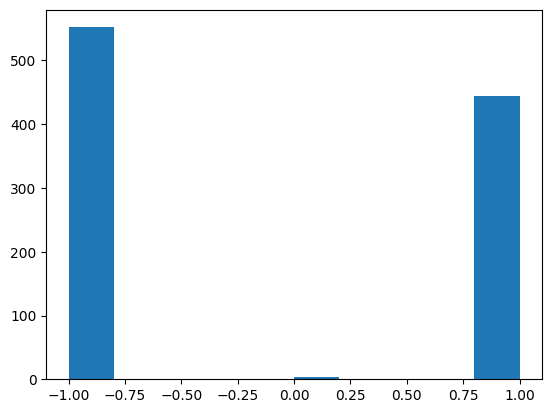

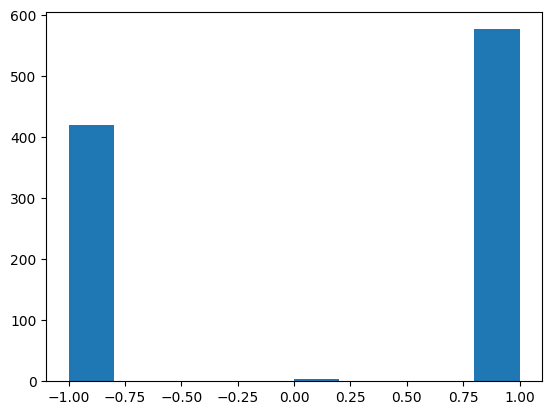

In [24]:
plt.hist(eval_against_policy(env, RandomPlayer(), RandomPlayer(), N_episodes=1000, first_player=False))
plt.show()
plt.hist(eval_against_policy(env, RandomPlayer(), RandomPlayer(), N_episodes=1000, first_player=True))
plt.show()

# Your turn 

Try to build a decent agent. Be creative! You can try any idea that you have: the grade is not about performance of the agent, but more about illustrating phenomena happening in Reinforcement Learning for turn-based games. It's okay to 'help' the agent in any way, as long as it follows the ideas of RL (i.e., as long as there is some learning involved).


